# Regression results - sel

This notebook displays the results of the regression model for biophony.

#### Import statements

In [2]:
from pymc3 import glm, Model, NUTS, sample, stats, \
                  forestplot, traceplot, plot_posterior, summary, \
                  Normal, Uniform, Deterministic, StudentT
from pymc3.backends import SQLite
from pymc3.backends.sqlite import load
from os import path

In [3]:
import pandas
import numpy
import seaborn
from matplotlib import pyplot
from matplotlib import rcParams
%matplotlib inline

In [4]:
rcParams['font.sans-serif'] = ['Helvetica',
                               'Arial',
                               'Bitstream Vera Sans',
                               'DejaVu Sans',
                               'Lucida Grande',
                               'Verdana',
                               'Geneva',
                               'Lucid',
                               'Avant Garde',
                               'sans-serif']

In [5]:
trace_input_filepath = "/home/ubuntu/data/model traces/sel"

In [6]:
data_filepath = "/home/ubuntu/data/dataset.csv"

In [7]:
seaborn_blue = seaborn.color_palette()[0]

In [8]:
data = pandas.read_csv(data_filepath)
data = data.loc[data.site<=30]

In [9]:
data_sorted = data.sort_values(by=['site', 'sound']).reset_index(drop=True)

In [10]:
data_sorted['land_composite_50m'] = (data_sorted.forest_50m - (data_sorted.building_50m + data_sorted.pavement_50m)) / (data_sorted.forest_50m + data_sorted.building_50m + data_sorted.pavement_50m)
data_sorted['land_composite_100m'] = (data_sorted.forest_100m - (data_sorted.building_100m + data_sorted.pavement_100m)) / (data_sorted.forest_100m + data_sorted.building_100m + data_sorted.pavement_100m)
data_sorted['land_composite_200m'] = (data_sorted.forest_200m - (data_sorted.building_200m + data_sorted.pavement_200m)) / (data_sorted.forest_200m + data_sorted.building_200m + data_sorted.pavement_200m)
data_sorted['land_composite_500m'] = (data_sorted.forest_500m - (data_sorted.building_500m + data_sorted.pavement_500m)) / (data_sorted.forest_500m + data_sorted.building_500m + data_sorted.pavement_500m)

In [11]:
column_list = ['sel', 'sel_anthrophony', 'sel_biophony', 'biophony', 'week', 
    'building_50m', 'pavement_50m', 'forest_50m', 'field_50m',
    'building_100m', 'pavement_100m', 'forest_100m', 'field_100m',
    'building_200m', 'pavement_200m', 'forest_200m', 'field_200m',
    'building_500m', 'pavement_500m', 'forest_500m', 'field_500m',
    'land_composite_50m', 'land_composite_100m', 'land_composite_200m', 'land_composite_500m',
    'temperature', 'wind_speed', 'pressure', 'bus_stop',
    'construction', 'crossing', 'cycleway', 'elevator', 'escape', 'footway',
    'living_street', 'motorway', 'motorway_link', 'path', 'pedestrian',
    'platform', 'primary_road', 'primary_link', 'proposed', 'residential',
    'rest_area', 'secondary', 'secondary_link', 'service', 'services',
    'steps', 'tertiary', 'tertiary_link', 'track', 'unclassified', 'combo']

data_centered = data_sorted.copy()
for column in column_list:
    data_centered[column] = data_sorted[column] - data_sorted[column].mean()

# copy land_composite values
land_composites = ['land_composite_50m', 'land_composite_100m', 'land_composite_200m', 'land_composite_500m']
for column in land_composites:
    data_centered[column] = data_sorted[column]

## Model 0

In [12]:
sites = numpy.copy(data_sorted.site.values) - 1

In [13]:
with Model() as model0:
    
    # Priors
    mu_grand = Normal('mu_grand', mu=0., tau=0.0001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    # Random intercepts
    a = Normal('a', mu=mu_grand, tau=tau_a, shape=len(set(sites)))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[sites]
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_centered.sel)

In [14]:
with model0:
    model0_samples = load(path.join(trace_input_filepath, "model0.sqlite"))

compute ICC

In [15]:
model0_samples.sigma_a[5000:].mean() / (model0_samples.sigma_y[5000:].mean() + model0_samples.sigma_a[5000:].mean())

0.62126673009833699

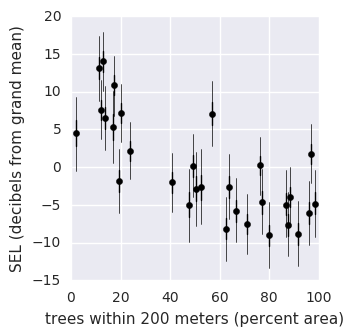

In [16]:
figure5, ax = pyplot.subplots()

figure5.set_figwidth(3.30)
figure5.set_figheight(3.30)

pyplot.subplots_adjust(left=0.2, bottom=0.15, right=0.95, top=0.95)

# organize results
model0_data = pandas.DataFrame({'site': data_sorted.site.unique(), 
                                 'site_name': data_sorted.site_name.unique()}).set_index('site')
model0_data['forest_200m'] = data.groupby('site').forest_200m.mean()
model0_data['quantiles'] = [stats.quantiles(model0_samples.a[:5000, i]) for i in range(len(set(sites)))]

# plot quantiles
for i, row in model0_data.sort_values(by='forest_200m').iterrows():
    x = row['forest_200m']
    ax.plot([x, x], [row['quantiles'][2.5], row['quantiles'][97.5]], color='black', linewidth=0.5)
    ax.plot([x, x], [row['quantiles'][25], row['quantiles'][75]], color='black', linewidth=1)
    ax.scatter([x], [row['quantiles'][50]], color='black', marker='o')

# format plot
l1 = ax.set_xlim([0, 100])
xl = ax.set_xlabel("trees within 200 meters (percent area)")
yl = ax.set_ylabel("SEL (decibels from grand mean)")

In [17]:
#figure5.savefig("/Users/Jake/Desktop/figure5.tiff", dpi=150)

## Model 1

In [18]:
sites = numpy.copy(data_sorted.site.values) - 1

In [19]:
site_predictors = [
    'building_50m', 'pavement_50m', 'forest_50m', 'field_50m',
    'building_100m', 'pavement_100m', 'forest_100m', 'field_100m',
    'building_200m', 'pavement_200m', 'forest_200m', 'field_200m',
    'building_500m', 'pavement_500m', 'forest_500m', 'field_500m',
    'land_composite_50m', 'land_composite_100m', 'land_composite_200m', 'land_composite_500m'
]

In [20]:
model1_models = dict()

In [21]:
def define_model1(predictor):
    with Model() as model1:
        # intercept
        g_a = Normal('g_a', mu=0, tau=0.001)
        g_as = Normal('g_as', mu=0, tau=0.001)
        sigma_a = Uniform('sigma_a', lower=0, upper=100)
        tau_a = sigma_a**-2
        mu_a = g_a + (g_as * data_centered.groupby('site')[predictor].mean())
        a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))

        # slope
        g_b = Normal('g_b', mu=0, tau=0.001)
        g_bs = Normal('g_bs', mu=0, tau=0.001)
        sigma_b = Uniform('sigma_b', lower=0, upper=100)
        tau_b = sigma_b**-2
        mu_b = g_b + (g_bs * data_centered.groupby('site')[predictor].mean())
        b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))

        # model error (data-level)
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        tau_y = sigma_y**-2

        # expected values
        y_hat = a[sites] + (b[sites] * data_centered.week)

        # likelihood
        y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_centered.sel)
    
    return model1

In [22]:
for predictor in site_predictors:
    model1_models[predictor] = define_model1(predictor)

In [23]:
def load_model1(predictor):
    with model1_models[predictor]:
        return load(path.join(trace_input_filepath, 
                              "model1_{0}.sqlite".format(predictor)))

In [24]:
model1_samples = dict()
for predictor in site_predictors:
    model1_samples[predictor] = load_model1(predictor)

calculate R squared

In [25]:
def calculate_R_squared(samples, varname, predictor):
    # level 2
    measured = samples[varname][5000:].mean(axis=0)
    g = samples['g_{0}'.format(varname)][5000:].mean()
    g_s = samples['g_{0}s'.format(varname)][5000:].mean()
    estimate = g + (g_s * data_centered.groupby('site')[predictor].mean())
    e = measured - estimate
    # R squared
    return 1 - (e.var() / measured.var())

In [26]:
table_2 = pandas.DataFrame({'variable': [p.split('_')[0] for p in site_predictors], 
                            'radius': [p.split('_')[-1:][0] for p in site_predictors], 
                            'intercept effect': ["{0:.3f}".format(model1_samples[p]['g_as'][5000:].mean()) for p in site_predictors],
                            'slope effect': ["{0:.3f}".format(model1_samples[p]['g_bs'][5000:].mean()) for p in site_predictors],
                            'intercept fit': ["{0:.2f}".format(calculate_R_squared(model1_samples[p], 'a', p)) for p in site_predictors],
                            'slope fit': ["{0:.2f}".format(calculate_R_squared(model1_samples[p], 'b', p)) for p in site_predictors]
                           }, columns=['variable', 'radius', 'intercept effect', 'intercept fit', 'slope effect', 'slope fit']).set_index('variable')
table_2.to_csv("/home/ubuntu/Table2b.csv")

In [27]:
table_2.sort_index()

,radius,intercept effect,intercept fit,slope effect,slope fit
variable,,,,,
building,50m,0.448,0.51,-0.002,0.02
building,100m,0.388,0.54,-0.003,0.14
building,200m,0.409,0.64,-0.005,0.63
building,500m,0.412,0.52,-0.005,0.19
field,50m,0.020,-0.03,0.007,0.80
field,100m,-0.007,-0.03,0.009,0.87
field,500m,-0.052,-0.02,0.013,0.86
field,200m,-0.005,-0.03,0.010,0.82
forest,50m,-0.147,0.62,-0.000,0.01


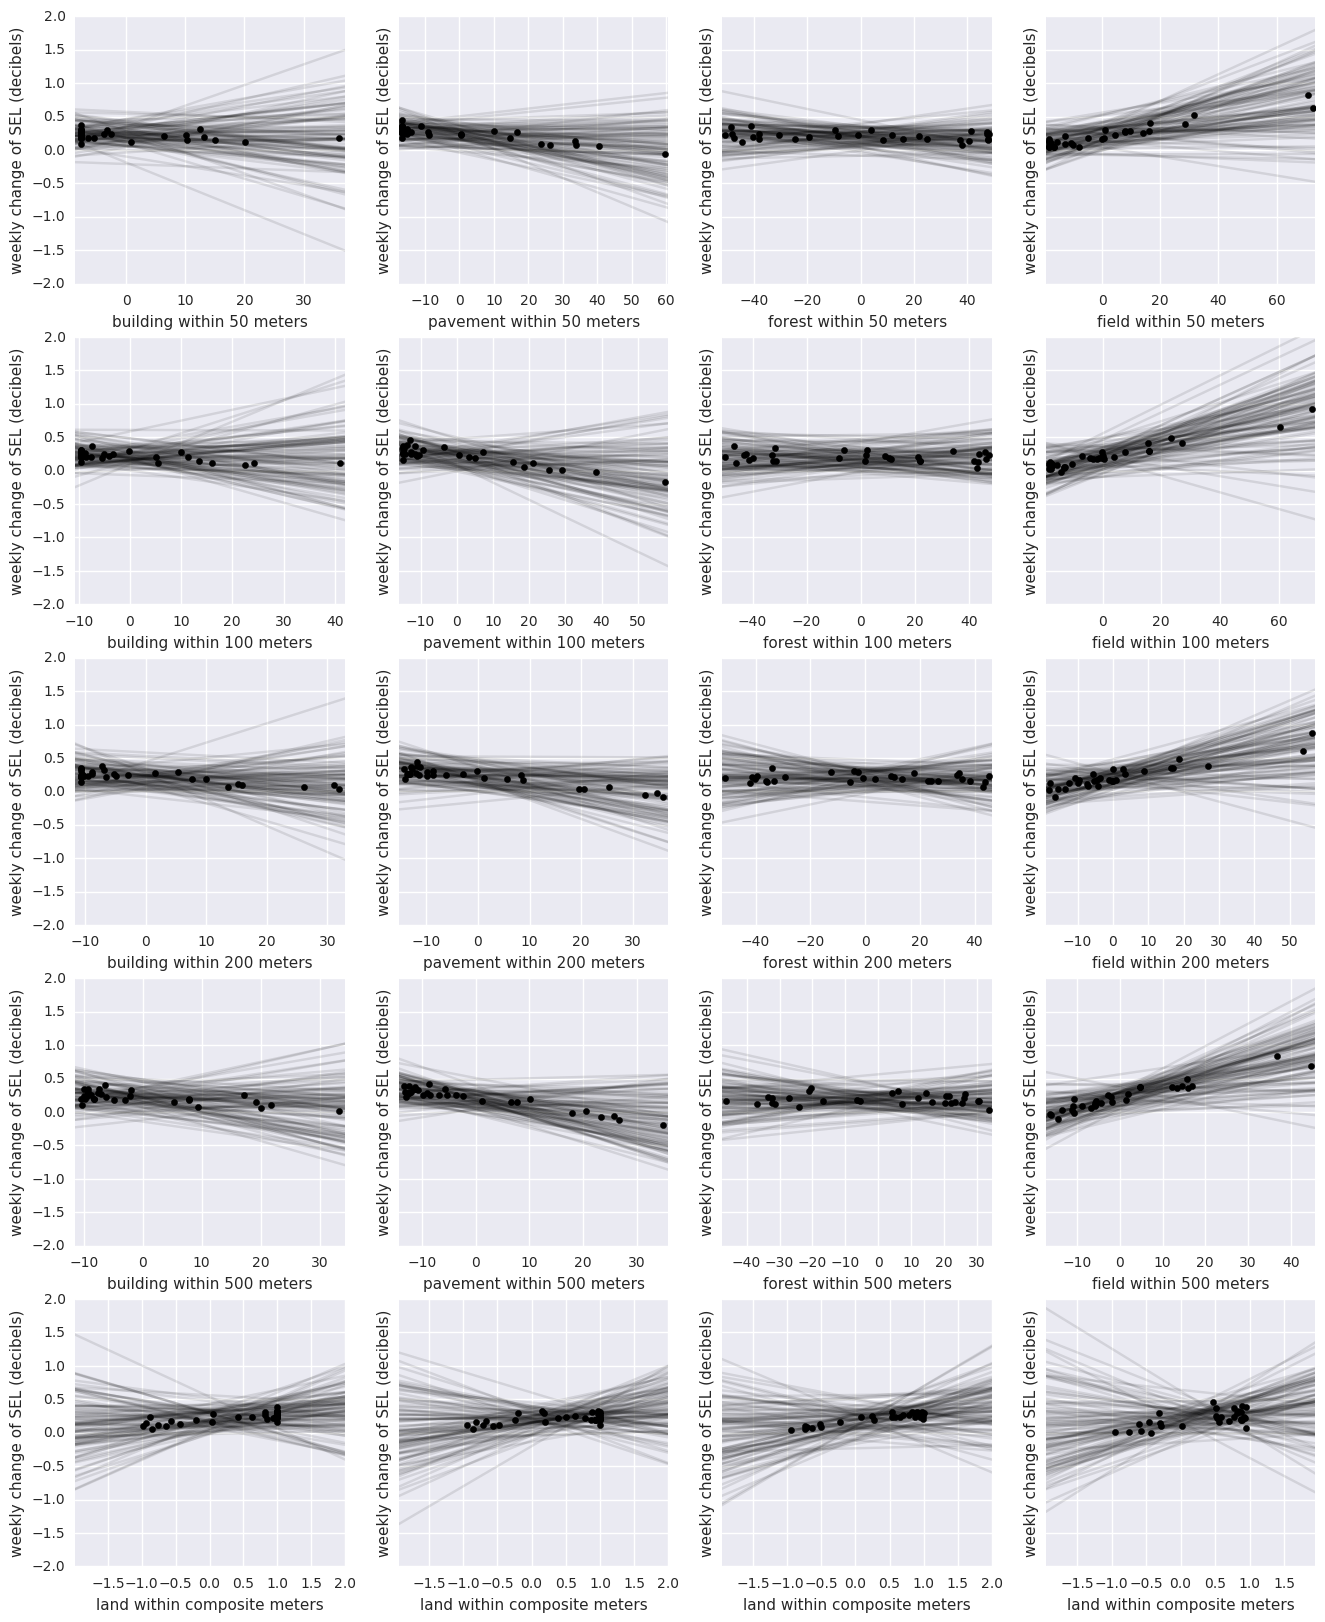

In [28]:
fig, ax = pyplot.subplots(5, 4, sharex=False, sharey=True)
ax = ax.ravel()
fig.set_figwidth(16)
fig.set_figheight(20)

for i, predictor in enumerate(site_predictors):
    # organize results
    samples = model1_samples[predictor]
    model1_data = pandas.DataFrame({'site': data_centered.site.unique(), 
                                     'site_name': data_centered.site_name.unique()}).set_index('site')
    model1_data[predictor] = data_centered.groupby('site')[predictor].mean()
    #model1_data['forest_200m'] = data_sorted.forest_200m.unique()
    #model1_data['quantiles_a'] = [stats.quantiles(model1_samples.a[:5000, i]) for i in range(len(set(sites)))]
    model1_data['quantiles_b'] = [stats.quantiles(samples.b[:5000, i]) for i in range(len(set(sites)))]

    for d in numpy.random.randint(5000, 9999, 100):
        xd = numpy.array([-100, 100])
        yd = samples.g_b[d] + (xd * samples.g_bs[d])
        ax[i].plot(xd, yd, color='black', alpha=0.1)
        
    # plot quantiles
    #predictor_mean = data[predictor].mean()
    x = model1_data[predictor]
    y = [r[50] for r in model1_data['quantiles_b']]
        #ax[i].plot([x, x], [row['quantiles_b'][2.5], row['quantiles_b'][97.5]], color='black', linewidth=0.5)
        #ax[i].plot([x, x], [row['quantiles_b'][25], row['quantiles_b'][75]], color='black', linewidth=1)
    ax[i].scatter(x, y, color='black', marker='o')

    # format plot
    #l1 = ax[i].set_xlim([-10, 110])
    lx = ax[i].set_xlim([model1_data[predictor].min() - 1, model1_data[predictor].max() + 1])
    ly = ax[i].set_ylim([-2, 2])
    xl = ax[i].set_xlabel("{0} within {1} meters".format(predictor.split("_")[0], predictor.split("_")[1].rstrip("m")))
    yl = ax[i].set_ylabel("weekly change of SEL (decibels)")

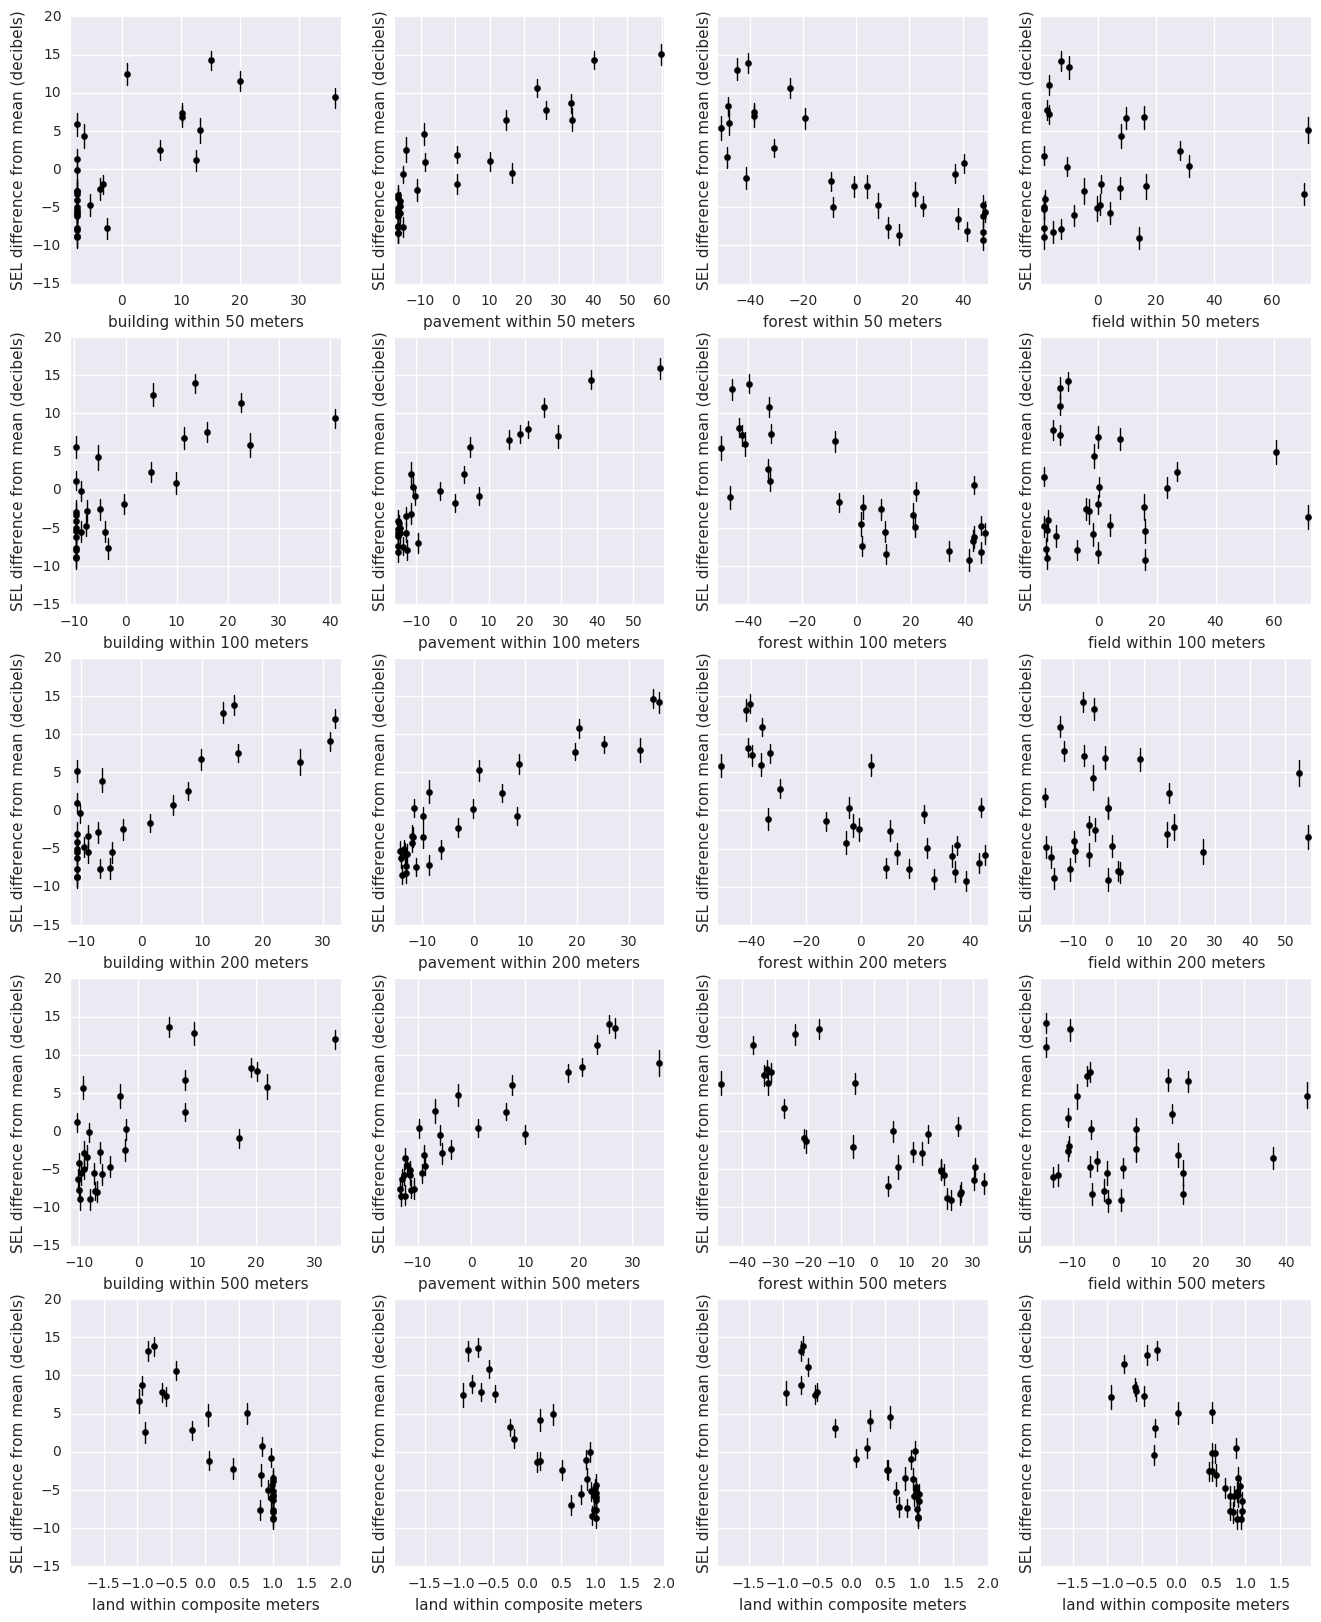

In [29]:
fig, ax = pyplot.subplots(5, 4, sharex=False, sharey=True)
ax = ax.ravel()
fig.set_figwidth(16)
fig.set_figheight(20)

for i, predictor in enumerate(site_predictors):
    # organize results
    samples = model1_samples[predictor]
    model1_data = pandas.DataFrame({'site': data_centered.site.unique(), 
                                     'site_name': data_centered.site_name.unique()}).set_index('site')
    model1_data[predictor] = data_centered.groupby('site')[predictor].mean()
    #model1_data['forest_200m'] = data_sorted.forest_200m.unique()
    model1_data['quantiles_a'] = [stats.quantiles(samples.a[:5000, i]) for i in range(len(set(sites)))]
    #model1_data['quantiles_b'] = [stats.quantiles(samples.b[:5000, i]) for i in range(len(set(sites)))]

    # plot quantiles
    for idx, row in model1_data.sort_values(by=predictor).iterrows():
        x = row[predictor]
        #ax[i].plot([x, x], [row['quantiles_b'][2.5], row['quantiles_b'][97.5]], color='black', linewidth=0.5)
        ax[i].plot([x, x], [row['quantiles_a'][25], row['quantiles_a'][75]], color='black', linewidth=1)
        ax[i].scatter([x], [row['quantiles_a'][50]], color='black', marker='o')

    # format plot
    l1 = ax[i].set_xlim([model1_data[predictor].min() - 1, model1_data[predictor].max() + 1])
    xl = ax[i].set_xlabel("{0} within {1} meters".format(predictor.split("_")[0], predictor.split("_")[1].rstrip("m")))
    yl = ax[i].set_ylabel("SEL difference from mean (decibels)")

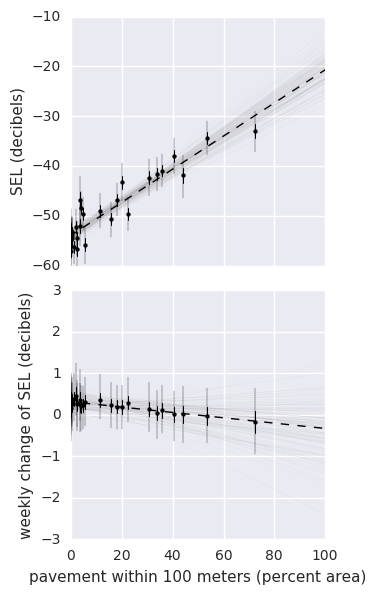

In [30]:
predictor = "pavement_100m"

fig, ax = pyplot.subplots(2, 1, sharex=True, sharey=False)
fig.set_figwidth(3.30)
fig.set_figheight(3.30 * 1.8)
pyplot.subplots_adjust(left=0.19, bottom=0.10, right=0.96, top = 0.98, hspace=0.1, wspace=0)

# organize results
samples = model1_samples[predictor]
model1_data = pandas.DataFrame({'site': data_centered.site.unique(), 
                                 'site_name': data_centered.site_name.unique()}).set_index('site')
model1_data[predictor] = data_centered.groupby('site')[predictor].mean()
model1_data['quantiles_a'] = [stats.quantiles(samples.a[:5000, i]) for i in range(len(set(sites)))]
model1_data['quantiles_b'] = [stats.quantiles(samples.b[:5000, i]) for i in range(len(set(sites)))]

# transform to original values (not mean centered)
y_trans = data_sorted['sel'].mean()

xd = numpy.array([-100, 100])
for d in numpy.random.randint(5000, 9999, 100):
    yd = (samples.g_a[d] + y_trans) + (xd * samples.g_as[d])
    ax[0].plot(xd, yd, color='gray', alpha=0.1, linewidth=0.25)

for d in numpy.random.randint(5000, 9999, 100):
    xd = numpy.array([-100, 100])
    yd = samples.g_b[d] + (xd * samples.g_bs[d])
    ax[1].plot(xd, yd, color='gray', alpha=0.1, linewidth=0.25)
    
# plot quantiles
x = model1_data[predictor]
y = [r[50] + y_trans for r in model1_data['quantiles_a']]
ax[0].scatter(x, y, color='black', marker='.', s=30, zorder=1000)
ax[0].plot([x, x], [[r[25] + y_trans for r in model1_data['quantiles_a']], [r[75] + y_trans for r in model1_data['quantiles_a']]], color='black', linewidth=0.75)
ax[0].plot([x, x], [[r[2.5] + y_trans for r in model1_data['quantiles_a']], [r[97.5] + y_trans for r in model1_data['quantiles_a']]], color='black', linewidth=0.25)
ax[0].plot(xd, (samples.g_a[:5000].mean() + y_trans) + (xd * samples.g_as[:5000].mean()), color='black', linestyle='--', linewidth=1)

x = model1_data[predictor]
y = [r[50] for r in model1_data['quantiles_b']]
ax[1].scatter(x, y, color='black', marker='.', s=30, zorder=1000)
ax[1].plot([x, x], [[r[25] for r in model1_data['quantiles_b']], [r[75] for r in model1_data['quantiles_b']]], color='black', linewidth=0.75)
ax[1].plot([x, x], [[r[2.5] for r in model1_data['quantiles_b']], [r[97.5] for r in model1_data['quantiles_b']]], color='black', linewidth=0.25)
ax[1].plot(xd, samples.g_b[:5000].mean() + (xd * samples.g_bs[:5000].mean()), color='black', linestyle='--', linewidth=1)

# format plot
zero = 0 - data[predictor].mean()
xticks = numpy.arange(zero, zero + 120, 20)
xticklabels = [str(n) for n in range(0, 120, 20)]

#l1 = ax[1].set_xlim([-10, 110])
lx0 = ax[0].set_xlim([zero, zero + 100])
lx1 = ax[1].set_xlim([zero, zero + 100])
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticklabels)
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticklabels)
ly0 = ax[0].set_ylim([-60, -10])
ly1 = ax[1].set_ylim([-3, 3])
#xl0 = ax[0].set_xlabel("{0} within {1} meters (percent area)".format(predictor.split("_")[0], predictor.split("_")[1].rstrip("m")))
yl0 = ax[0].set_ylabel("SEL (decibels)")
xl1 = ax[1].set_xlabel("{0} within {1} meters (percent area)".format(predictor.split("_")[0], predictor.split("_")[1].rstrip("m")))
yl1 = ax[1].set_ylabel("weekly change of SEL (decibels)")

In [31]:
#fig.savefig("/home/ubuntu/download/figure6b.tiff", dpi=150)

In [32]:
trace = model1_samples['pavement_100m'][5000:]
a_means = trace['a'].mean(axis=0)
b_means = trace['b'].mean(axis=0)

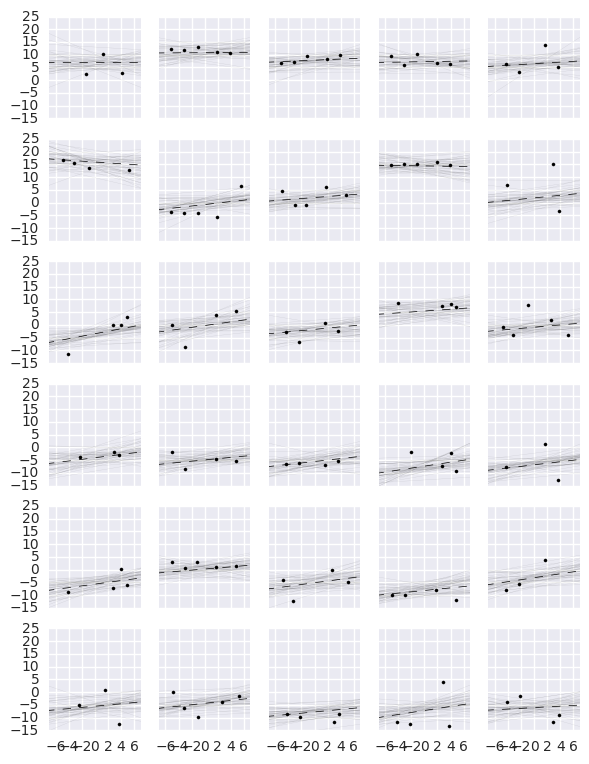

In [35]:
fig, ax = pyplot.subplots(6, 5, figsize=(6.85, 9.21), sharey=True, sharex=True)
ax = ax.ravel()
sites = data_centered[['site', 'land_composite_500m']].sort_values(by='land_composite_500m').site.unique()
for i, site in enumerate(sites):
    
    x_week = numpy.linspace(-10, 10, 2)
    
    # draw parameter samples
    for d in numpy.random.randint(0, 4999, 50):
        ax[i].plot(x_week, 
                   (trace['b'][d][site - 1] * x_week) + trace['a'][d][site - 1], 
                   color='black', marker=None, alpha=0.1, linewidth=0.25)
    
    # observed data (points)
    y = data_centered.sel[data_centered.site==site]
    x = data_centered.week[data_centered.site==site]
    ax[i].scatter(x, y, color='black', marker='.')
    
    # model estimate (line)
    ax[i].plot(x_week, a_means[site - 1] + (b_means[site - 1] * x_week), color='black', linestyle='--', linewidth=0.5)
    #ax[i].set_title("{0} - {1}".format(site, data_centered.site_name[data_centered.site == site].unique()[0]))
    #ax[i].text(-6, 5, "slope: {0:.02f}".format(b_means[site - 1]), va='bottom')
    #ax[i].text(-6, 15, "{0}".format(site), va='bottom')
    ax[i].set_xlim([-7, 7])
    ax[i].set_ylim([-15, 25])
    
    

In [34]:
g_a = trace['g_a'].mean(axis=0)
g_as = trace['g_as'].mean(axis=0)
g_b = trace['g_b'].mean(axis=0)
g_bs = trace['g_bs'].mean(axis=0)

In [35]:
g_a

-0.087634166111848752

In [36]:
g_as

0.33143409202279267

In [37]:
g_b

0.2192998649543067

In [38]:
g_bs

-0.0065262893929605497

In [34]:
fig.savefig("/home/ubuntu/download/Appendix2.tiff", dpi=150)

In [39]:
data_sorted.sel.mean()

-48.864103195171559

## Model 2a

In [49]:
sites = numpy.copy(data_sorted.site.values) - 1

In [50]:
measurement_predictors = [
    'temperature', 'wind_speed', 'precipitation', 'pressure'
]

In [51]:
model2a_models = dict()

In [52]:
def define_model2a(predictor):
    with Model() as model2a:

        # intercept
        g_a = Normal('g_a', mu=0, tau=0.001)
        g_as = Normal('g_as', mu=0, tau=0.001)
        sigma_a = Uniform('sigma_a', lower=0, upper=100)
        tau_a = sigma_a**-2
        mu_a = g_a + (g_as * data_centered.groupby('site')['forest_200m'].mean())
        a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))

        # time slope
        g_b = Normal('g_b', mu=0, tau=0.001)
        g_bs = Normal('g_bs', mu=0, tau=0.001)
        sigma_b = Uniform('sigma_b', lower=0, upper=100)
        tau_b = sigma_b**-2
        mu_b = g_b + (g_bs * data_centered.groupby('site')['forest_200m'].mean())
        b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))

        # predictor slope
        c = Uniform('c', lower=-100, upper=100)

        # model error (data-level)
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        tau_y = sigma_y**-2

        # expected values
        y_hat = a[sites] + (b[sites] * data_centered.week) + (c * data_centered[predictor])

        # likelihood
        y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_centered.anthrophony)
    
    return model2a

In [53]:
for predictor in measurement_predictors:
    model2a_models[predictor] = define_model2a(predictor)

Applied interval-transform to sigma_a and added transformed sigma_a_interval_ to model.
Applied interval-transform to sigma_b and added transformed sigma_b_interval_ to model.
Applied interval-transform to c and added transformed c_interval_ to model.
Applied interval-transform to sigma_y and added transformed sigma_y_interval_ to model.
Applied interval-transform to sigma_a and added transformed sigma_a_interval_ to model.
Applied interval-transform to sigma_b and added transformed sigma_b_interval_ to model.
Applied interval-transform to c and added transformed c_interval_ to model.
Applied interval-transform to sigma_y and added transformed sigma_y_interval_ to model.
Applied interval-transform to sigma_a and added transformed sigma_a_interval_ to model.
Applied interval-transform to sigma_b and added transformed sigma_b_interval_ to model.
Applied interval-transform to c and added transformed c_interval_ to model.
Applied interval-transform to sigma_y and added transformed sigma_y_

In [54]:
def load_model2a(predictor):
    with model2a_models[predictor]:
        return load(path.join(trace_input_filepath, 
                              "model2a_{0}.sqlite".format(predictor)))

In [55]:
model2a_samples = dict()
for predictor in measurement_predictors:
    model2a_samples[predictor] = load_model2a(predictor)

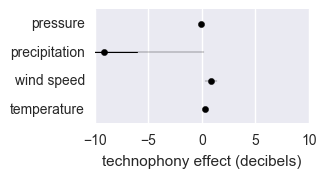

In [57]:
fig, ax = pyplot.subplots()
fig.set_figwidth(3.30)
fig.set_figheight(3.30 / 2)

fig.subplots_adjust(left=0.3, bottom=0.3, right=0.95, top=0.99)

model2a_data = pandas.DataFrame({'predictor': measurement_predictors,
                                 'quantiles_c': [stats.quantiles(model2a_samples[p].c) for p in measurement_predictors]})

x = numpy.arange(len(measurement_predictors))
ax.plot([[y[2.5] for y in model2a_data['quantiles_c']], [y[97.5] for y in model2a_data['quantiles_c']]],
        [x, x], color='black', linewidth=0.25)
ax.plot([[y[25] for y in model2a_data['quantiles_c']], [y[75] for y in model2a_data['quantiles_c']]],
        [x, x], color='black', linewidth=0.75)
ax.scatter([y[50] for y in model2a_data['quantiles_c']], 
            x, color='black', marker='o')
ax.set_xlim([-10, 10])

# format plot
l1 = ax.set_xlabel("technophony effect (decibels)")
l2 = ax.set_yticks(range(len(measurement_predictors)))
l3 = ax.set_yticklabels([p.replace('_', ' ') for p in measurement_predictors])
ax.grid(False, which='major', axis='y')

## Model 2b

In [177]:
sites = numpy.copy(data_sorted.site.values) - 1

In [178]:
measurement_predictors = [
    'temperature', 'wind_speed', 'precipitation', 'pressure'
]

In [179]:
model2b_models = dict()

In [180]:
def define_model2b(predictor):
    with Model() as model2b:
        
        # intercept
        g_a = Normal('g_a', mu=0, tau=0.001)
        g_as = Normal('g_as', mu=0, tau=0.001)
        sigma_a = Uniform('sigma_a', lower=0, upper=100)
        tau_a = sigma_a**-2
        mu_a = g_a + (g_as * data_centered.groupby('site')['forest_200m'].mean())
        a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))

        # time slope
        g_b = Normal('g_b', mu=0, tau=0.001)
        g_bs = Normal('g_bs', mu=0, tau=0.001)
        sigma_b = Uniform('sigma_b', lower=0, upper=100)
        tau_b = sigma_b**-2
        mu_b = g_b + (g_bs * data_centered.groupby('site')['forest_200m'].mean())
        b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))

        # predictor slope
        g_c = Normal('g_c', mu=0, tau=0.001)
        g_cs = Normal('g_cs', mu=0, tau=0.001)
        sigma_c = Uniform('sigma_c', lower=0, upper=100)
        tau_c = sigma_c**-2
        mu_c = g_c + (g_cs * data_centered.groupby('site')['forest_200m'].mean())
        c = Normal('c', mu=mu_c, tau=tau_c, shape=len(set(sites)))

        # model error (data-level)
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        tau_y = sigma_y**-2

        # expected values
        y_hat = a[sites] + (b[sites] * data_centered.week) + (c[sites] * data_centered[predictor])

        # likelihood
        y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_centered.biophony)
    
    return model2b

In [181]:
for predictor in measurement_predictors:
    model2b_models[predictor] = define_model2b(predictor)

Applied interval-transform to sigma_a and added transformed sigma_a_interval_ to model.
Applied interval-transform to sigma_b and added transformed sigma_b_interval_ to model.
Applied interval-transform to sigma_c and added transformed sigma_c_interval_ to model.
Applied interval-transform to sigma_y and added transformed sigma_y_interval_ to model.
Applied interval-transform to sigma_a and added transformed sigma_a_interval_ to model.
Applied interval-transform to sigma_b and added transformed sigma_b_interval_ to model.
Applied interval-transform to sigma_c and added transformed sigma_c_interval_ to model.
Applied interval-transform to sigma_y and added transformed sigma_y_interval_ to model.
Applied interval-transform to sigma_a and added transformed sigma_a_interval_ to model.
Applied interval-transform to sigma_b and added transformed sigma_b_interval_ to model.
Applied interval-transform to sigma_c and added transformed sigma_c_interval_ to model.
Applied interval-transform to si

In [182]:
def load_model2b(predictor):
    with model2b_models[predictor]:
        return load(path.join(trace_input_filepath, 
                              "model2b_{0}.sqlite".format(predictor)))

In [183]:
model2b_samples = dict()
for predictor in measurement_predictors:
    model2b_samples[predictor] = load_model2b(predictor)

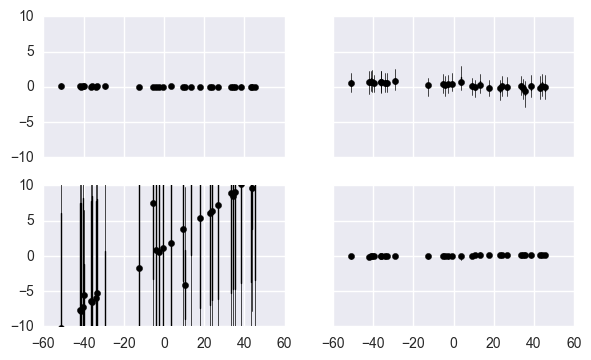

In [188]:
fig, axes = pyplot.subplots(2, 2, sharex=True, sharey=True)
ax = axes.ravel()
fig.set_figwidth(6.85)

for i, predictor in enumerate(measurement_predictors):
    # organize results
    samples = model2b_samples[predictor]
    model2b_data = pandas.DataFrame({'site': data_centered.site.unique(), 
                                     'site_name': data_centered.site_name.unique()}).set_index('site')
    model2b_data['forest_200m'] = data_centered.groupby('site')['forest_200m'].mean()
    model2b_data['quantiles_c'] = [stats.quantiles(samples.c[:5000, i]) for i in range(len(set(sites)))]

    # plot quantiles
    for idx, row in model2b_data.sort_values(by='forest_200m').iterrows():
        x = row['forest_200m']
        ax[i].plot([x, x], [row['quantiles_c'][2.5], row['quantiles_c'][97.5]], color='black', linewidth=0.5)
        ax[i].plot([x, x], [row['quantiles_c'][25], row['quantiles_c'][75]], color='black', linewidth=1)
        ax[i].scatter([x], [row['quantiles_c'][50]], color='black', marker='o')

    # format plot
    ax[i].set_ylim([-10, 10])
    #l1 = ax[i].set_xlim([model2b_data[predictor].min() - 10, model2b_data[predictor].max() + 10])
    #xl = ax[i].set_xlabel("{0} within {1} meters".format(predictor.split("_")[0], predictor.split("_")[1].rstrip("m")))
    #yl = ax[i].set_ylabel("biophony difference from mean (decibels)")